In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np


# Define which device to use for computations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare data for training and model selection

In [ ]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

In [ ]:
# Build a simple MNIST dataset
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize

transforms = Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))])
Mnist_dataset = MNIST('.', train=True, download=True, transform=transforms)

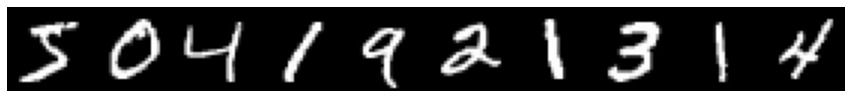

In [ ]:
# Visualize some samples
plt.figure(figsize=(15,7))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(Mnist_dataset[i][0][0], cmap='gray')
    plt.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
#plt.show()

### MnistPairs dataset

In [ ]:
# Build training and test sets with the 'right' and 'left' orders  of the digits.
from dataset import MnistPairs
from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import DataLoader

transforms = Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))])

train_right_dataset_ = MnistPairs('.', train=True,  download=True, transform=transforms, order='right', return_original_labels=True)
train_left_dataset_  = MnistPairs('.', train=True,  download=True, transform=transforms, order='left',  return_original_labels=True)
test_right_dataset   = MnistPairs('.', train=False, download=True, transform=transforms, order='right', return_original_labels=True)
test_left_dataset    = MnistPairs('.', train=False, download=True, transform=transforms, order='left',  return_original_labels=True)

In [ ]:
# Set aside 90% of training data for training, and the remaining 10% for validation
from torch.utils.data import random_split

train_right_size = int(0.9*len(train_right_dataset_))             
valid_right_size = len(train_right_dataset_) - train_right_size  
train_right_dataset, valid_right_dataset = random_split(train_right_dataset_, [train_right_size, valid_right_size])

train_left_size = int(0.9*len(train_left_dataset_))
valid_left_size = len(train_left_dataset_) - train_left_size
train_left_dataset, valid_left_dataset = random_split(train_left_dataset_, [train_left_size, valid_left_size])

In [ ]:
# Concatenate the validation sets into one with both 'right' and 'left' orders. The same should be done with the test sets. 
from torch.utils.data import ConcatDataset

valid_dataset = ConcatDataset([valid_right_dataset, valid_left_dataset])
test_dataset  = ConcatDataset([test_right_dataset,  test_left_dataset])

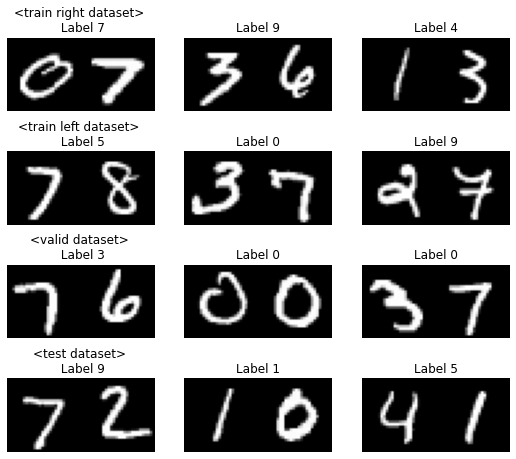

In [ ]:
# Visualize some samples from the constructed datasets
datasets = [train_right_dataset, train_left_dataset, valid_dataset, test_dataset]
datasets_name = ['<train right dataset>', '<train left dataset>', '<valid dataset>', '<test dataset>']

fig, axes = plt.subplots(4, 3, figsize=(9,8))
for i, dataset in enumerate(datasets):
    for j in range(3):
        ax = axes[i, j]
        ax.imshow(torch.cat((dataset[j][0][0], dataset[j][1][0]), dim=1), cmap='gray')
        if j == 0: ax.set_title('{} \n Label {}'.format(datasets_name[i], dataset[j][2]))
        if j != 0:ax.set_title('Label {}'.format(dataset[j][2]))
        ax.axis('off')
plt.show()

### Label and Pair Distribution

In [ ]:
import seaborn as sns
import pandas as pd

def calculate_distribution_of_labels(dataset, name_dataset):
    labels = []
    first_labels  = []
    second_labels = []
    for i in range(len(dataset)):
        labels.append(dataset[i][2])
        first_labels.append(dataset[i][3])
        second_labels.append(dataset[i][4])

    df = pd.DataFrame({'labels':labels, 'First_labels':first_labels, 'Second_labels':second_labels})
    pv = pd.pivot_table(df, index='First_labels', columns='Second_labels', values='labels', aggfunc='count')

    # Plot
    fig, axes = plt.subplots(1,2, figsize=(15,5))
    label, counts = np.unique(labels, return_counts=True)
    axes[0].bar(label, counts, color='royalblue', alpha=0.8)
    axes[0].set_xticks(label)
    axes[0].set_xlabel('label')
    axes[0].set_title('Distribution of unique number of labels in the {} set'.format(name_dataset))

    sns.heatmap(pv, cbar=True, cmap='Blues', linewidth=0.1);
    axes[1].set_title('Distribution of each pair in the {} set'.format(name_dataset))
    axes[1].set_xlabel('Second label')
    axes[1].set_ylabel('First label')
    plt.show()
    pass

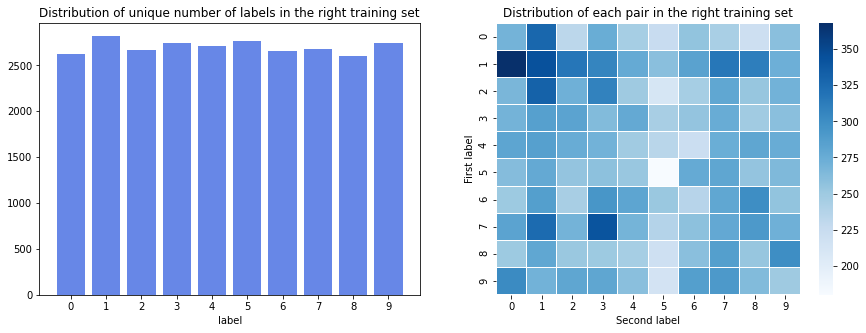

None


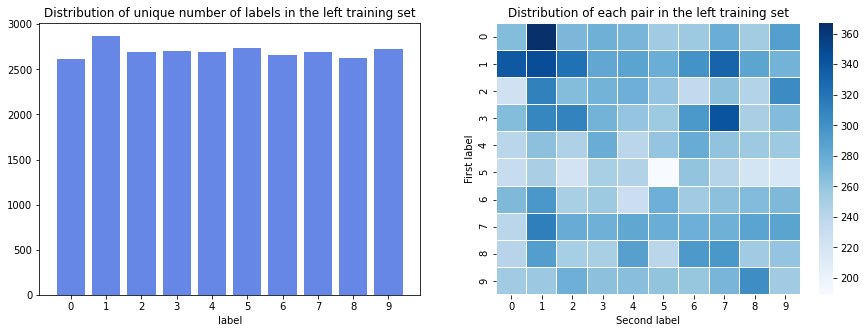

None


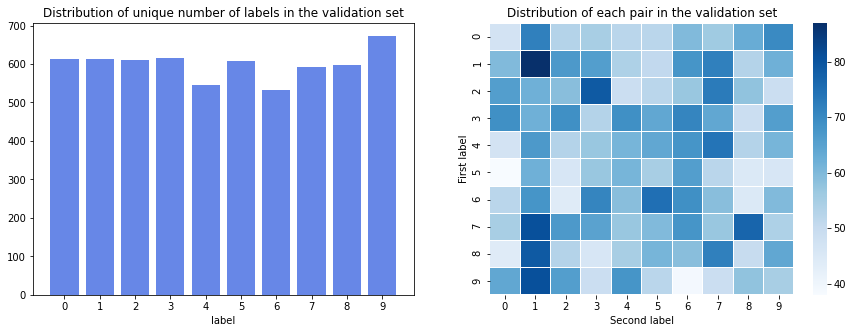

None


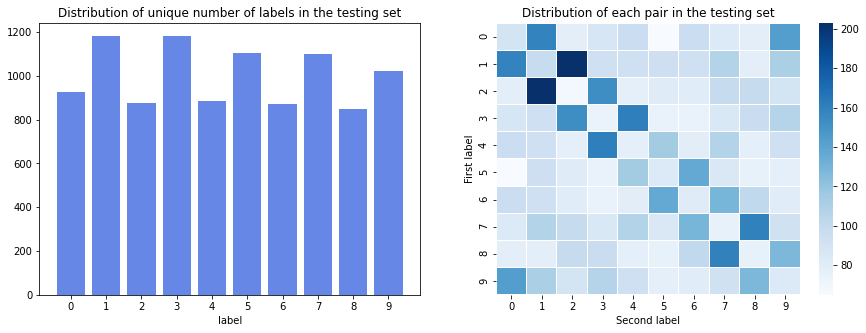

None


In [ ]:
print(calculate_distribution_of_labels(train_right_dataset, 'right training'))
print(calculate_distribution_of_labels(train_left_dataset, 'left training'))
print(calculate_distribution_of_labels(valid_dataset, 'validation'))
print(calculate_distribution_of_labels(test_dataset, 'testing'))

# Design training settings

In [ ]:
# Wrap the datasets with a DataLoader
from torch.utils.data import DataLoader

train_right_dataloader = DataLoader(train_right_dataset, batch_size=64, shuffle=True, num_workers=2)
train_left_dataloader  = DataLoader(train_left_dataset,  batch_size=64, shuffle=True, num_workers=2)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=2)
test_dataloader  = DataLoader(test_dataset,  batch_size=64, shuffle=False, num_workers=2)

In [ ]:
# Model 1
import torch.nn as nn
class Module4Model1(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Module4Model1, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim*2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 10),
        )

    def forward(self, input1, input2):
        out = torch.cat((input1, input2), dim=1) 
        out = out.view(out.size(0), -1)          
        out = self.layers(out)                
        return out


model1 = Module4Model1(input_dim=28*28, hidden_dim=1024).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.05)

In [ ]:
# Model 2
import torch.nn as nn
class Module4Model2(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2):
        super(Module4Model2, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim*2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, 10),
        )

    def forward(self, input1, input2):
        out = torch.cat((input1, input2), dim=1) 
        out = out.view(out.size(0), -1)          
        out = self.layers(out)                
        return out

model2 = Module4Model2(input_dim=28*28, hidden_dim1=1024, hidden_dim2=512).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.05)

In [ ]:
# Model 3
import torch.nn as nn
class Module4Model3(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2):
        super(Module4Model3, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim*2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, 10),
        )

    def forward(self, input1, input2):
        out = torch.cat((input1, input2), dim=1) 
        out = out.view(out.size(0), -1)          
        out = self.layers(out)                
        return out

model3 = Module4Model3(input_dim=28*28, hidden_dim1=512, hidden_dim2=256).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer3 = torch.optim.SGD(model3.parameters(), lr=0.01)

In [ ]:
# Training

def accuracy(labels, predictions):
    return (predictions==labels).sum().item()

def train_model(model, dataloader, optimizer):
    losses = []
    predictions = 0
    for images1, images2, labels, labels1, labels2 in dataloader:
        images1 = images1.to(device)
        images2 = images2.to(device)
        labels = labels.to(device)

        output = model(images1, images2)
        optimizer.zero_grad()
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
            
        losses.append(loss.item())
        predicted = output.argmax(1)
        predictions += accuracy(labels, predicted)
    
    train_loss     = sum(losses) / len(losses)
    train_accuracy = 100 * predictions / len(dataloader.dataset)
    return train_loss, train_accuracy

def evaluate_model(model, dataloader):
    losses = []
    predictions = 0
    with torch.no_grad():
        for images1, images2, labels, _,_ in dataloader:
            images1 = images1.to(device)
            images2 = images2.to(device)
            labels = labels.to(device)

            output = model(images1, images2)
            loss = loss_fn(output, labels)
                
            losses.append(loss.item())
            predicted = output.argmax(1)
            predictions += accuracy(labels, predicted)

    valid_loss = sum(losses) / len(losses)
    valid_accuracy = 100 * predictions / len(dataloader.dataset)
    return valid_loss, valid_accuracy

def train_evaluate_together(model, train_dataloader, valid_dataloader, optimizer, num_epochs):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_accuracy = train_model(model, train_dataloader, optimizer)

        model.eval()
        valid_loss, valid_accuracy = evaluate_model(model, valid_dataloader)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)
        print('Epoch {:2}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, valid_loss: {:.4f}, valid_accuracy: {:.4f}'.format(epoch+1, num_epochs,
                                                                                                                             train_losses[-1], train_accuracies[-1],
                                                                                                                             valid_losses[-1], valid_accuracies[-1]))
    return train_losses, valid_losses, train_accuracies, valid_accuracies

def plot(num_epochs, train_losses, train_accuracies, valid_losses, valid_accuracies, title):
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    axes[0].plot(np.arange(num_epochs), train_losses)
    axes[0].plot(np.arange(num_epochs), valid_losses)
    axes[0].legend(['train loss', 'valid loss'])
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss Value')
    axes[0].set_title('{}: Train & Valid Loss'.format(title))

    axes[1].plot(np.arange(num_epochs), train_accuracies)
    axes[1].plot(np.arange(num_epochs), valid_accuracies)
    axes[1].legend(['train accuracy', 'valid accuracy'])
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('{}: Train & Valid Accuracy'.format(title))
    plt.tight_layout()
    plt.show()

# Train on training 'right' set.

In [ ]:
# Model 1
train_losses1, valid_losses1, train_accuracies1, valid_accuracies1 = train_evaluate_together(model1, train_right_dataloader, valid_dataloader, 
                                                                                            optimizer1, num_epochs=25)

Epoch  1/25: train_loss: 2.2244, train_accuracy: 19.0185, valid_loss: 2.1132, valid_accuracy: 22.2167
Epoch  2/25: train_loss: 1.7703, train_accuracy: 39.4926, valid_loss: 1.7101, valid_accuracy: 40.4833
Epoch  3/25: train_loss: 1.3873, train_accuracy: 53.2481, valid_loss: 1.4266, valid_accuracy: 52.4333
Epoch  4/25: train_loss: 1.1451, train_accuracy: 61.8926, valid_loss: 1.2653, valid_accuracy: 57.9833
Epoch  5/25: train_loss: 0.9970, train_accuracy: 67.1593, valid_loss: 1.2234, valid_accuracy: 58.7167
Epoch  6/25: train_loss: 0.8798, train_accuracy: 71.7667, valid_loss: 1.1170, valid_accuracy: 63.1667
Epoch  7/25: train_loss: 0.7854, train_accuracy: 74.7741, valid_loss: 1.1979, valid_accuracy: 60.1667
Epoch  8/25: train_loss: 0.7056, train_accuracy: 77.5444, valid_loss: 1.0619, valid_accuracy: 65.5500
Epoch  9/25: train_loss: 0.6492, train_accuracy: 79.1815, valid_loss: 1.0810, valid_accuracy: 65.5667
Epoch 10/25: train_loss: 0.5902, train_accuracy: 81.3593, valid_loss: 1.0604, vali

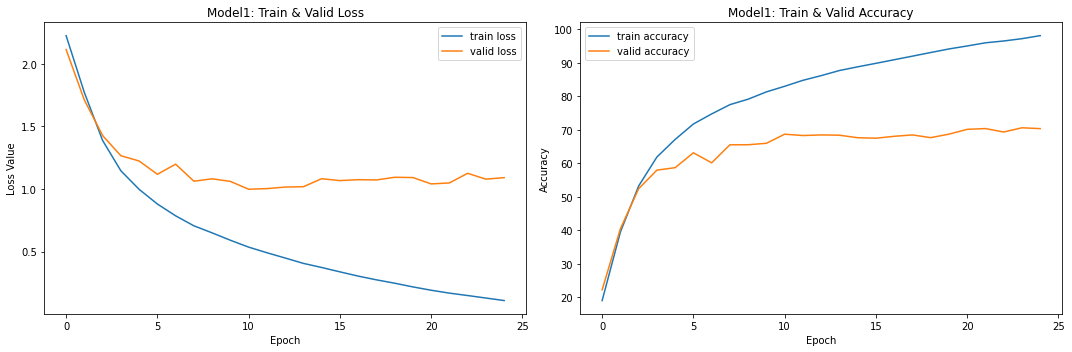

In [ ]:
plot(25, train_losses1, train_accuracies1, valid_losses1, valid_accuracies1, title='Model1')

In [ ]:
# Model 2
train_losses2, valid_losses2, train_accuracies2, valid_accuracies2 = train_evaluate_together(model2, train_right_dataloader, valid_dataloader, 
                                                                                            optimizer2, num_epochs=25)

Epoch  1/25: train_loss: 2.2821, train_accuracy: 14.3519, valid_loss: 2.2391, valid_accuracy: 17.2667
Epoch  2/25: train_loss: 1.9927, train_accuracy: 30.6296, valid_loss: 1.8230, valid_accuracy: 35.4333
Epoch  3/25: train_loss: 1.4923, train_accuracy: 49.1481, valid_loss: 1.4456, valid_accuracy: 51.4667
Epoch  4/25: train_loss: 1.1032, train_accuracy: 63.4222, valid_loss: 1.1372, valid_accuracy: 62.8500
Epoch  5/25: train_loss: 0.8547, train_accuracy: 73.1704, valid_loss: 0.9479, valid_accuracy: 70.2000
Epoch  6/25: train_loss: 0.6918, train_accuracy: 78.7370, valid_loss: 0.8962, valid_accuracy: 71.7500
Epoch  7/25: train_loss: 0.5762, train_accuracy: 82.2963, valid_loss: 0.7788, valid_accuracy: 75.9333
Epoch  8/25: train_loss: 0.4901, train_accuracy: 85.0000, valid_loss: 0.7715, valid_accuracy: 76.0333
Epoch  9/25: train_loss: 0.4242, train_accuracy: 87.1370, valid_loss: 0.7175, valid_accuracy: 77.7833
Epoch 10/25: train_loss: 0.3635, train_accuracy: 88.9741, valid_loss: 0.7596, vali

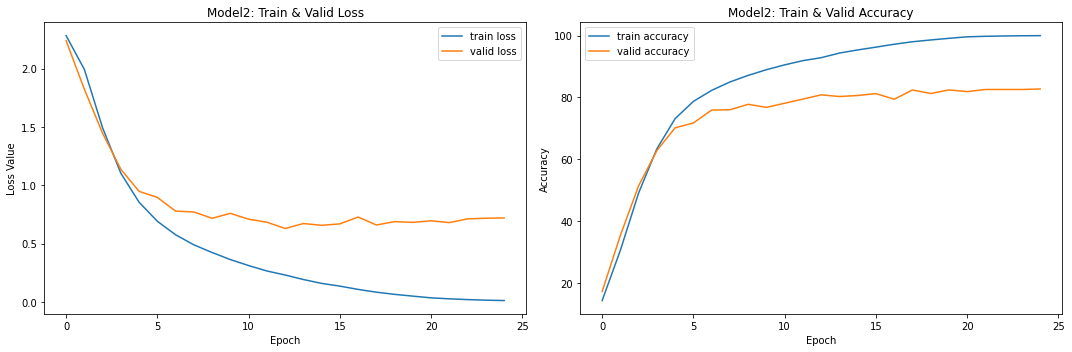

In [ ]:
plot(25, train_losses2, train_accuracies2, valid_losses2, valid_accuracies2, title='Model2')

In [ ]:
# Model 3
train_losses3, valid_losses3, train_accuracies3, valid_accuracies3 = train_evaluate_together(model3, train_right_dataloader, valid_dataloader, 
                                                                                            optimizer3, num_epochs=25)

Epoch  1/25: train_loss: 2.3009, train_accuracy: 11.1815, valid_loss: 2.2997, valid_accuracy: 11.3667
Epoch  2/25: train_loss: 2.2919, train_accuracy: 14.0481, valid_loss: 2.2913, valid_accuracy: 13.8333
Epoch  3/25: train_loss: 2.2799, train_accuracy: 16.5704, valid_loss: 2.2835, valid_accuracy: 15.5500
Epoch  4/25: train_loss: 2.2612, train_accuracy: 20.4111, valid_loss: 2.2626, valid_accuracy: 18.2000
Epoch  5/25: train_loss: 2.2271, train_accuracy: 23.9000, valid_loss: 2.2285, valid_accuracy: 23.0667
Epoch  6/25: train_loss: 2.1645, train_accuracy: 29.2889, valid_loss: 2.1552, valid_accuracy: 27.5333
Epoch  7/25: train_loss: 2.0492, train_accuracy: 34.6111, valid_loss: 2.0341, valid_accuracy: 32.1500
Epoch  8/25: train_loss: 1.8829, train_accuracy: 39.9815, valid_loss: 1.8991, valid_accuracy: 34.7167
Epoch  9/25: train_loss: 1.7105, train_accuracy: 44.3667, valid_loss: 1.7392, valid_accuracy: 41.9167
Epoch 10/25: train_loss: 1.5635, train_accuracy: 48.6741, valid_loss: 1.6297, vali

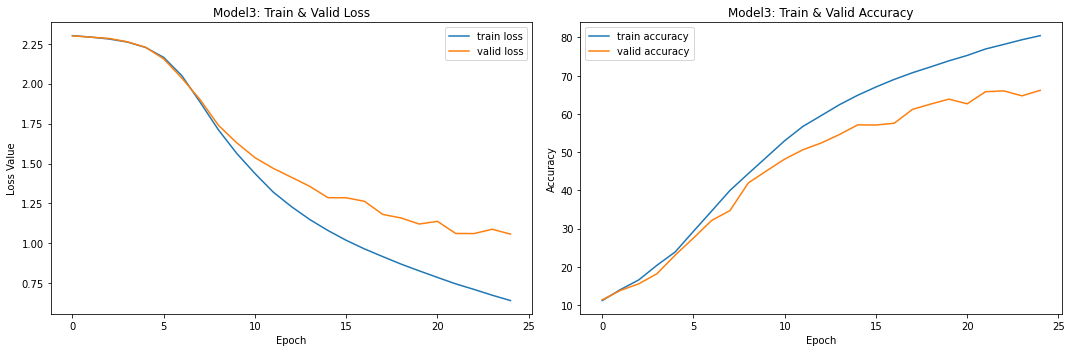

In [ ]:
plot(25, train_losses3, train_accuracies3, valid_losses3, valid_accuracies3, title='Model3')

# Train on concatenated training set.

In [ ]:
# Concatenate the right and left oder training datasets
train_dataset = ConcatDataset([train_right_dataset, train_left_dataset])
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

In [ ]:
# Model1
model1_c = Module4Model1(input_dim=28*28, hidden_dim=1024).to(device)
optimizer1 = torch.optim.SGD(model1_c.parameters(), lr=0.05)

train_losses1_c, valid_losses1_c, train_accuracies1_c, valid_accuracies1_c = train_evaluate_together(model1_c, train_dataloader, valid_dataloader, 
                                                                                                    optimizer1, num_epochs=25)

Epoch  1/25: train_loss: 2.0698, train_accuracy: 25.6370, valid_loss: 1.6600, valid_accuracy: 42.8000
Epoch  2/25: train_loss: 1.4169, train_accuracy: 51.8630, valid_loss: 1.2566, valid_accuracy: 57.5000
Epoch  3/25: train_loss: 1.0916, train_accuracy: 64.0352, valid_loss: 1.0744, valid_accuracy: 64.2667
Epoch  4/25: train_loss: 0.9214, train_accuracy: 70.1796, valid_loss: 0.9649, valid_accuracy: 68.9000
Epoch  5/25: train_loss: 0.8053, train_accuracy: 74.1870, valid_loss: 0.8996, valid_accuracy: 70.9833
Epoch  6/25: train_loss: 0.7183, train_accuracy: 77.1852, valid_loss: 0.8233, valid_accuracy: 73.8167
Epoch  7/25: train_loss: 0.6554, train_accuracy: 79.2648, valid_loss: 0.8974, valid_accuracy: 71.5333
Epoch  8/25: train_loss: 0.6017, train_accuracy: 81.0407, valid_loss: 0.8126, valid_accuracy: 74.7333
Epoch  9/25: train_loss: 0.5525, train_accuracy: 82.6204, valid_loss: 0.7559, valid_accuracy: 76.3167
Epoch 10/25: train_loss: 0.5058, train_accuracy: 84.1074, valid_loss: 0.7748, vali

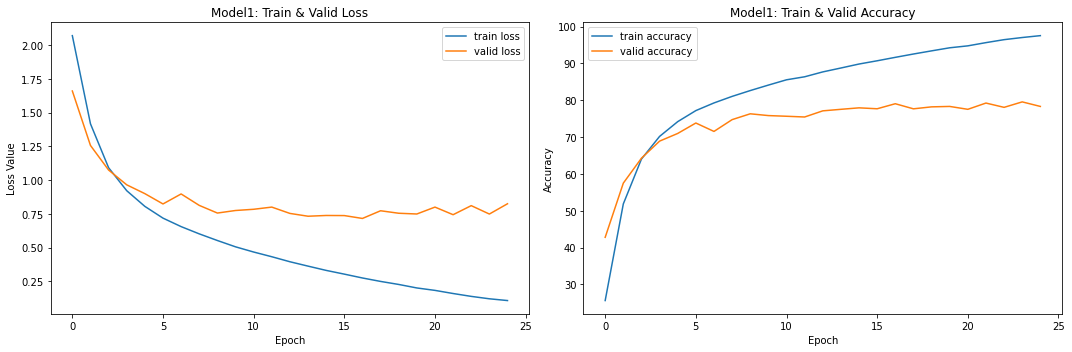

In [ ]:
plot(25, train_losses1_c, train_accuracies1_c, valid_losses1_c, valid_accuracies1_c, title='Model1')

In [ ]:
# Model2
model2_c = Module4Model2(input_dim=28*28, hidden_dim1=1024, hidden_dim2=512).to(device)
optimizer2 = torch.optim.SGD(model2_c.parameters(), lr=0.05)

train_losses2_c, valid_losses2_c, train_accuracies2_c, valid_accuracies2_c = train_evaluate_together(model2_c, train_dataloader, valid_dataloader, 
                                                                                                    optimizer2, num_epochs=25)

Epoch  1/25: train_loss: 2.2016, train_accuracy: 19.3944, valid_loss: 1.9072, valid_accuracy: 31.6000
Epoch  2/25: train_loss: 1.4539, train_accuracy: 50.2370, valid_loss: 1.1735, valid_accuracy: 60.6167
Epoch  3/25: train_loss: 0.9025, train_accuracy: 71.2074, valid_loss: 0.8120, valid_accuracy: 74.2667
Epoch  4/25: train_loss: 0.6549, train_accuracy: 79.8370, valid_loss: 0.7139, valid_accuracy: 77.8000
Epoch  5/25: train_loss: 0.5186, train_accuracy: 84.2519, valid_loss: 0.5840, valid_accuracy: 82.2000
Epoch  6/25: train_loss: 0.4284, train_accuracy: 87.0611, valid_loss: 0.5024, valid_accuracy: 84.5667
Epoch  7/25: train_loss: 0.3607, train_accuracy: 89.0426, valid_loss: 0.5047, valid_accuracy: 84.6000
Epoch  8/25: train_loss: 0.3044, train_accuracy: 90.7815, valid_loss: 0.4616, valid_accuracy: 85.8667
Epoch  9/25: train_loss: 0.2604, train_accuracy: 91.9704, valid_loss: 0.4282, valid_accuracy: 86.9667
Epoch 10/25: train_loss: 0.2209, train_accuracy: 93.2907, valid_loss: 0.4208, vali

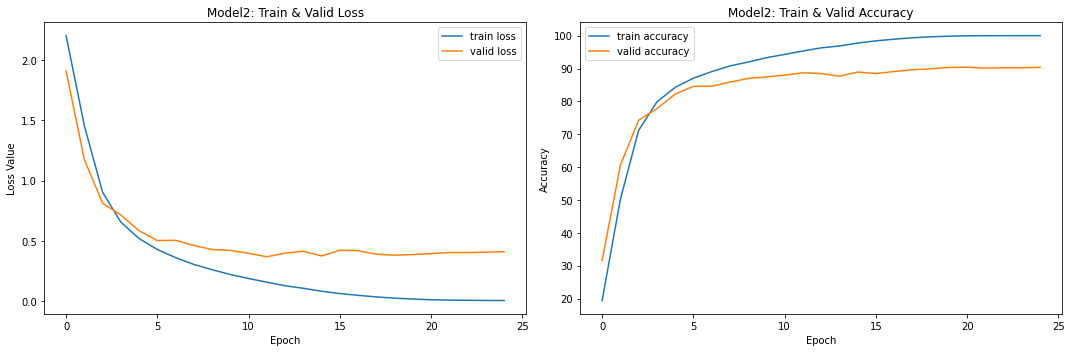

In [ ]:
plot(25, train_losses2_c, train_accuracies2_c, valid_losses2_c, valid_accuracies2_c, title='Model2')

In [ ]:
# Model3
model3_c = Module4Model3(input_dim=28*28, hidden_dim1=512, hidden_dim2=256).to(device)
optimizer3 = torch.optim.SGD(model3_c.parameters(), lr=0.01)

train_losses3_c, valid_losses3_c, train_accuracies3_c, valid_accuracies3_c = train_evaluate_together(model3_c, train_dataloader, valid_dataloader, 
                                                                                                    optimizer3, num_epochs=25)

Epoch  1/25: train_loss: 2.2970, train_accuracy: 12.2889, valid_loss: 2.2894, valid_accuracy: 14.6833
Epoch  2/25: train_loss: 2.2739, train_accuracy: 17.4685, valid_loss: 2.2588, valid_accuracy: 19.0000
Epoch  3/25: train_loss: 2.2088, train_accuracy: 23.6500, valid_loss: 2.1497, valid_accuracy: 24.9167
Epoch  4/25: train_loss: 2.0290, train_accuracy: 31.5130, valid_loss: 1.9029, valid_accuracy: 35.4167
Epoch  5/25: train_loss: 1.7765, train_accuracy: 40.2537, valid_loss: 1.6568, valid_accuracy: 45.4667
Epoch  6/25: train_loss: 1.5557, train_accuracy: 47.9519, valid_loss: 1.5086, valid_accuracy: 49.3833
Epoch  7/25: train_loss: 1.3709, train_accuracy: 54.6926, valid_loss: 1.3229, valid_accuracy: 56.4333
Epoch  8/25: train_loss: 1.2241, train_accuracy: 59.8500, valid_loss: 1.1831, valid_accuracy: 61.6000
Epoch  9/25: train_loss: 1.1006, train_accuracy: 64.4370, valid_loss: 1.0886, valid_accuracy: 65.0833
Epoch 10/25: train_loss: 0.9975, train_accuracy: 68.3093, valid_loss: 1.0065, vali

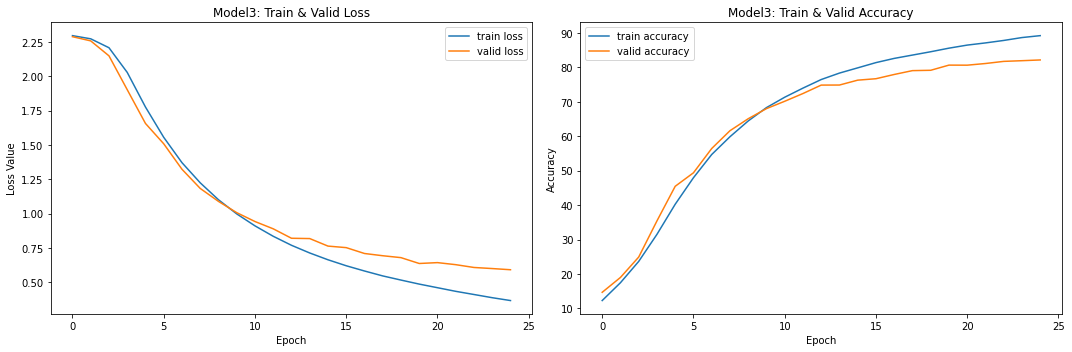

In [ ]:
plot(25, train_losses3_c, train_accuracies3_c, valid_losses3_c, valid_accuracies3_c, title='Model3')

# Evaluation

In [ ]:
# Evaluate the model on the test set and report the accuracy
def test_model(model, test_dataloader):
    predictions = 0
    with torch.no_grad():
        for images1, images2, labels, _,_ in test_dataloader:
            images1 = images1.to(device)
            images2 = images2.to(device)
            labels = labels.to(device)

            output = model(images1, images2)
            predicted = output.argmax(1)
            predictions += accuracy(labels, predicted)

    test_accuracy = 100 * predictions / len(test_dataloader.dataset)
    print('Accuracy on the {} test images: {}%'.format(len(test_dataset), test_accuracy))
    pass

In [ ]:
test_model(model2_c, test_dataloader)

Accuracy on the 10000 test images: 90.98%


# Visualizations

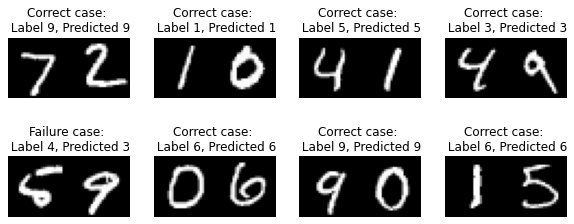

In [ ]:
# Visualize a few samples from the test dataset (both correct and failure cases)
with torch.no_grad():
    for images1, images2, labels, _,_ in test_dataloader:
        images1 = images1.to(device)
        images2 = images2.to(device)
        labels = labels.to(device)

        output = model2_c(images1, images2)
        predicted = output.argmax(1)
        predictions = (labels==predicted).squeeze()

        plt.figure(figsize=(10,4))
        for i in range(8):
            plt.subplot(2,4,i+1)
            if labels[i].item() == predicted[i].item():
                plt.imshow(torch.cat((images1[i][0], images2[i][0]), dim=1), cmap='gray')
                plt.title('Correct case: \n Label {}, Predicted {}'.format(labels[i], predicted[i]))
                plt.axis('off')
            elif labels[i].item() != predicted[i].item():
                plt.imshow(torch.cat((images1[i][0], images2[i][0]), dim=1), cmap='gray')
                plt.title('Failure case: \n Label {}, Predicted {}'.format(labels[i], predicted[i]))
                plt.axis('off')
        break

In [ ]:
# Visualize the accuracy depending on the digit pairs
pairs_predictions = pd.DataFrame(0, index=[0,1,2,3,4,5,6,7,8,9] , columns=[0,1,2,3,4,5,6,7,8,9])
pairs_total       = pd.DataFrame(0, index=[0,1,2,3,4,5,6,7,8,9] , columns=[0,1,2,3,4,5,6,7,8,9])

with torch.no_grad():
    for images1, images2, labels, labels1, labels2 in test_dataloader:
        images1 = images1.to(device)
        images2 = images2.to(device)
        labels  = labels.to(device)
        labels1 = labels1.to(device)
        labels2 = labels2.to(device)

        output = model2_c(images1, images2)
        predicted = output.argmax(1)
        predictions = (labels==predicted).squeeze()

        for i in range(images1.size(0)): 
            first_label   = labels1[i].item()
            second_label = labels2[i].item()
            pairs_predictions.iloc[first_label, second_label] += predictions[i].item()
            pairs_total.iloc[first_label, second_label] += 1
                    
pairs_accuracy = (100*(pairs_predictions / pairs_total)).round(2)

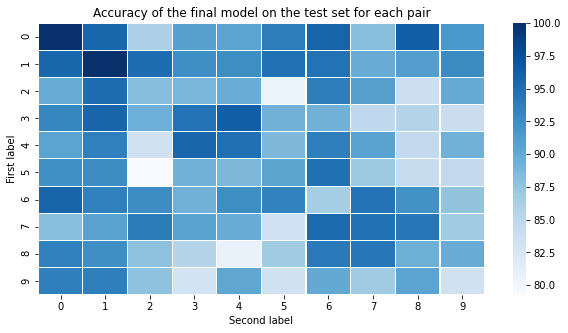

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

sns.heatmap(pairs_accuracy, cbar=True, cmap='Blues', linewidth=0.1)
ax.set_title('Accuracy of the final model on the test set for each pair')
ax.set_xlabel('Second label')
ax.set_ylabel('First label')
plt.show()